In [7]:
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
%matplotlib inline

## Cost to DAG run duration

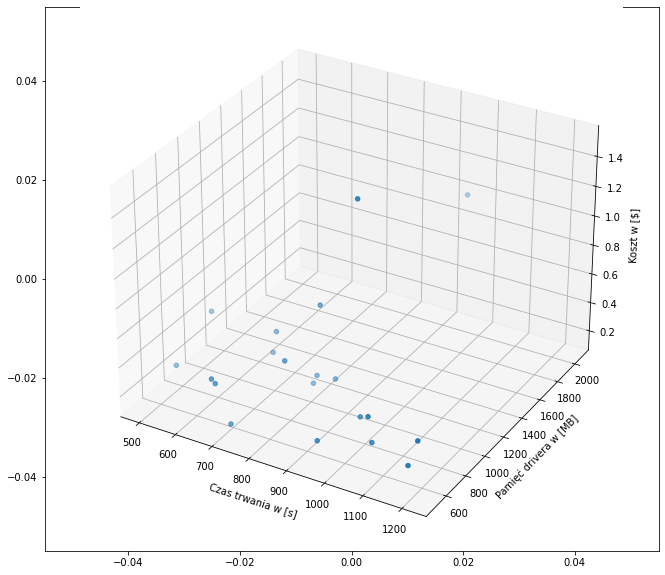

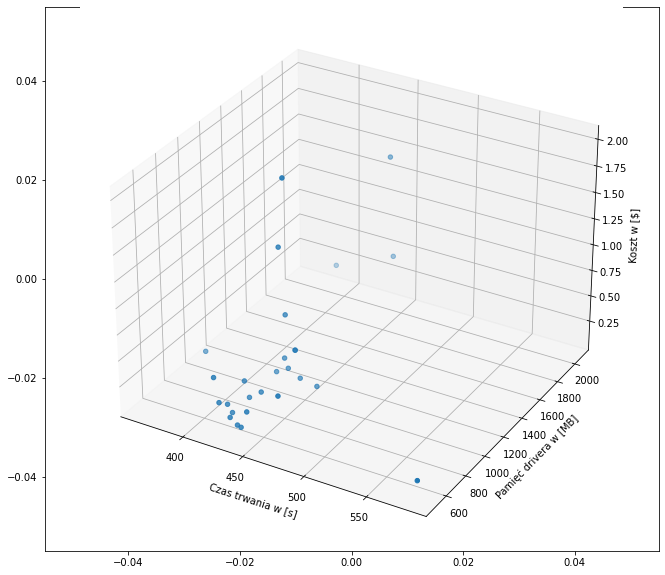

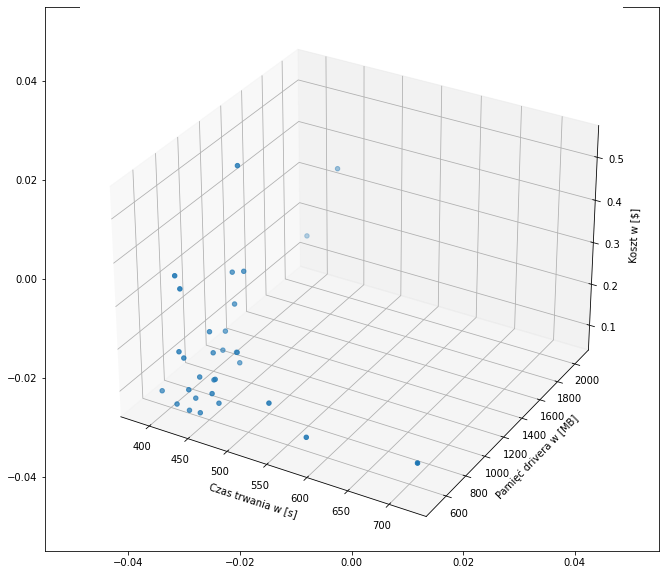

In [8]:
filenames = ['prom_data_e2-standard-2' ,'prom_data_e2-standard-4', 'prom_data_n1-standard-4']
machine_cost_conversion = {
    'n1': (3.75, 0.04749975),
    'e2': (4.0, 0.067006)
}

#  wzór kosztu:
#   (max{(l. corów / l.exec), (pamięć RAM maszyny / executor_memory * driver_memory)} * (dag_duration / 60)) * const_cost / 60

def cost_function(r, machine):
    splitted_machine_type = machine.split('-')
    core_number = int(splitted_machine_type[2])
    # podwojenie liczby corów podwaja koszt
    cost = core_number/2 * machine_cost_conversion[splitted_machine_type[0]][1]
    # ramu 4 razy więcej niż l. corów
    ram_memory = machine_cost_conversion[splitted_machine_type[0]][0] * core_number
    return max(r['executor_instances']/core_number, ((r['executor_memory'] * r['executor_instances'] + r['driver_memory'])/ram_memory) / 16) * (r['dag_duration'] / 60) * cost/60
    # return (max(core_number/r['executor_instances'], ram_memory/r['executor_memory'] * r['driver_memory']) * r['dag_duration'] / 60) * cost / 60

for file in filenames:
    data = pd.read_csv(file + ".csv")
    data['executor_memory'] = data['executor_memory'].str.replace('m', '')
    data['driver_memory'] = data['driver_memory'].str.replace('m', '')
    data['executor_memory'] = pd.to_numeric(data['executor_memory'])
    data['driver_memory'] = pd.to_numeric(data['driver_memory'])
    data['status'] = data['status'].map({'success': 'sukces', 'failed': 'niepowodzenie'})

    data['cost'] = 0.0 # new cost column
    machine_type = data['machine_type'][0]
    for index, row in data.iterrows():
        data.at[index, 'cost'] = cost_function(row, machine_type)

    fig = px.scatter(data, x="cost", y="dag_duration",labels={
                     "cost": "Koszt w [$]",
                     "dag_duration": "Czas trwania w [s]",
                     "executor_instances": "Liczba executorów",
                     "executor_memory": "Pamięć executora w [MB]",
                     "driver_memory": "Pamięć drivera w [MB]"
                 }, color_discrete_map={
                        "sukces": "green",
                        "niepowodzenie": "red"},
                    color="status", title="Typ maszyny {}".format(machine_type), hover_data=['executor_instances', 'executor_memory', 'driver_memory'])
    fig.show()

    fig = px.scatter(data, x="dag_duration", y="executor_instances",labels={
                     "cost": "Koszt w [$]",
                     "dag_duration": "Czas trwania w [s]",
                     "executor_instances": "Liczba executorów",
                     "executor_memory": "Pamięć executora w [MB]",
                     "driver_memory": "Pamięć drivera w [MB]"
                 }, color_discrete_map={
                        "sukces": "green",
                        "niepowodzenie": "red"},
                    color="status", title="Typ maszyny {}".format(machine_type), hover_data=['executor_instances', 'executor_memory', 'driver_memory'])
    fig.show()

    data.sort_values(by=['cost', 'dag_duration'], inplace=True)

    fig = plt.figure(figsize=(11,10))
    plt.autoscale()
    ax = fig.add_subplot(111, projection='3d')
    X = data['dag_duration'].to_numpy()
    Y = data['driver_memory'].to_numpy()
    Z = data['cost'].to_numpy()
    ax.scatter(X, Y, Z)
    ax.set_xlabel("Czas trwania w [s]")
    ax.set_ylabel("Pamięć drivera w [MB]")
    ax.set_zlabel("Koszt w [$]")

    fig = px.scatter_3d(data, x="dag_duration", y="driver_memory", z="cost", color="status", title="Typ maszyny {}".format(machine_type),
                        hover_data=['executor_instances', 'executor_memory', 'driver_memory'], labels={
                     "cost": "Koszt w [$]",
                     "dag_duration": "Czas trwania w [s]",
                     "executor_instances": "Liczba executorów",
                     "executor_memory": "Pamięć executora w [MB]",
                     "driver_memory": "Pamięć drivera w [MB]"
                 }, color_discrete_map={
                        "sukces": "green",
                        "niepowodzenie": "red"}, width=800, height=800)
    fig.update_traces(marker=dict(size=3))
    fig.show()

    data['cost'] = data['cost'].round(2)
    data.to_csv(file + "-cost.csv", index=False)